# Détection de Fraude Bancaire avec Deep Learning

Ce notebook présente une analyse complète d'un projet de détection de fraude bancaire utilisant des techniques de Deep Learning. Nous utilisons le dataset "Credit Card Fraud Detection" de Kaggle, qui contient des transactions réelles effectuées par des cartes de crédit.

## Objectifs

1. Prétraiter les données (normalisation, rééquilibrage des classes)
2. Créer un modèle de Deep Learning avec TensorFlow
3. Évaluer et optimiser le modèle
4. Analyser les problèmes et proposer des solutions
5. Explorer des extensions possibles (LSTM, GRU, déploiement)

## 1. Installation des bibliothèques nécessaires

In [1]:
# Installation des bibliothèques nécessaires
!pip install pandas numpy matplotlib seaborn scikit-learn tensorflow keras-tuner imbalanced-learn shap lime


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2. Importation des bibliothèques

In [21]:
# Bibliothèques de base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# Prétraitement et évaluation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from imblearn.over_sampling import SMOTE

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import kerastuner as kt

# Interprétabilité
import shap
import lime
import lime.lime_tabular

# Configuration
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
np.random.seed(42)
tf.random.set_seed(42)

## 3. Téléchargement et exploration des données

Le dataset est disponible sur Kaggle : https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [3]:
# Téléchargement du dataset depuis Kaggle (nécessite une configuration de l'API Kaggle)
# !kaggle datasets download -d mlg-ulb/creditcardfraud
# !unzip creditcardfraud.zip

# Si vous avez déjà téléchargé le dataset, vous pouvez le charger directement
df = pd.read_csv('C:\\Users\\sanat\\Downloads\\archive\\creditcard.csv')

# Affichage des premières lignes
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Informations sur le dataset
print(f"Nombre de transactions : {df.shape[0]}")
print(f"Nombre de colonnes : {df.shape[1]}")
print("\nInformations sur les colonnes :")
df.info()

Nombre de transactions : 284807
Nombre de colonnes : 31

Informations sur les colonnes :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 1

In [5]:
# Statistiques descriptives
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Transactions normales : 284315 (99.83%)
Transactions frauduleuses : 492 (0.17%)


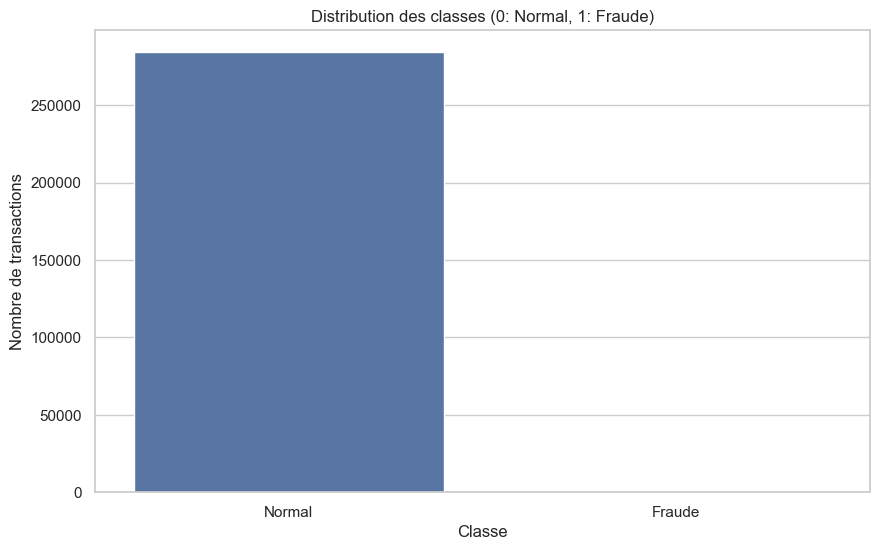

In [6]:
# Vérification du déséquilibre des classes
class_counts = df['Class'].value_counts()
print(f"Transactions normales : {class_counts[0]} ({class_counts[0]/len(df)*100:.2f}%)")
print(f"Transactions frauduleuses : {class_counts[1]} ({class_counts[1]/len(df)*100:.2f}%)")

import os
os.makedirs('images', exist_ok=True)

# Visualisation de la distribution des classes
plt.figure(figsize=(10, 6))
sns.countplot(x='Class', data=df)
plt.title('Distribution des classes (0: Normal, 1: Fraude)')
plt.xlabel('Classe')
plt.ylabel('Nombre de transactions')
plt.xticks([0, 1], ['Normal', 'Fraude'])
plt.savefig('images/distribution_classes_avant.png', dpi=300, bbox_inches='tight')
plt.show()

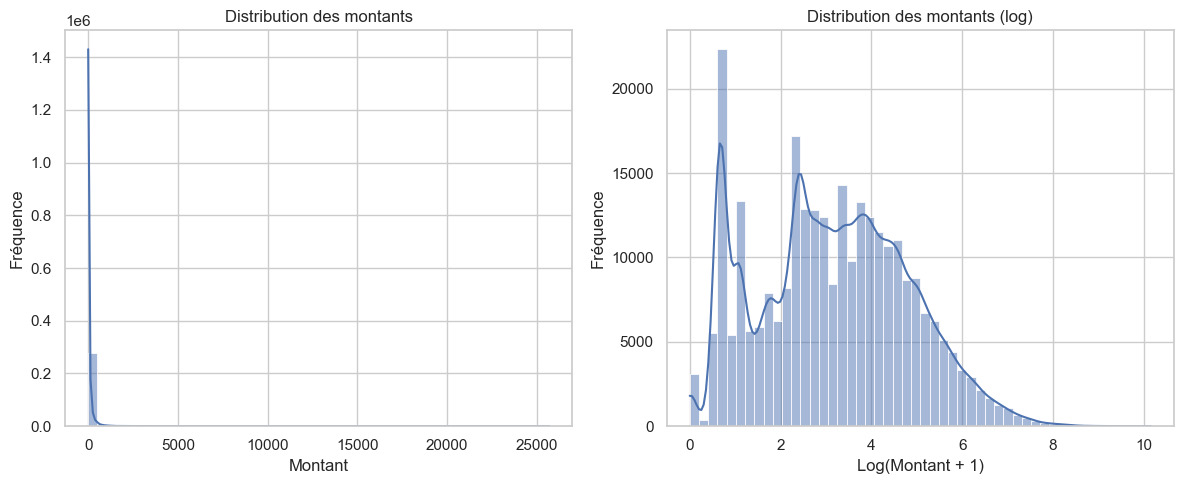

In [7]:
# Visualisation de la distribution des montants
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title('Distribution des montants')
plt.xlabel('Montant')
plt.ylabel('Fréquence')

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(df['Amount']), bins=50, kde=True)
plt.title('Distribution des montants (log)')
plt.xlabel('Log(Montant + 1)')
plt.ylabel('Fréquence')

plt.tight_layout()
plt.savefig('images/distribution_montants.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Prétraitement des données

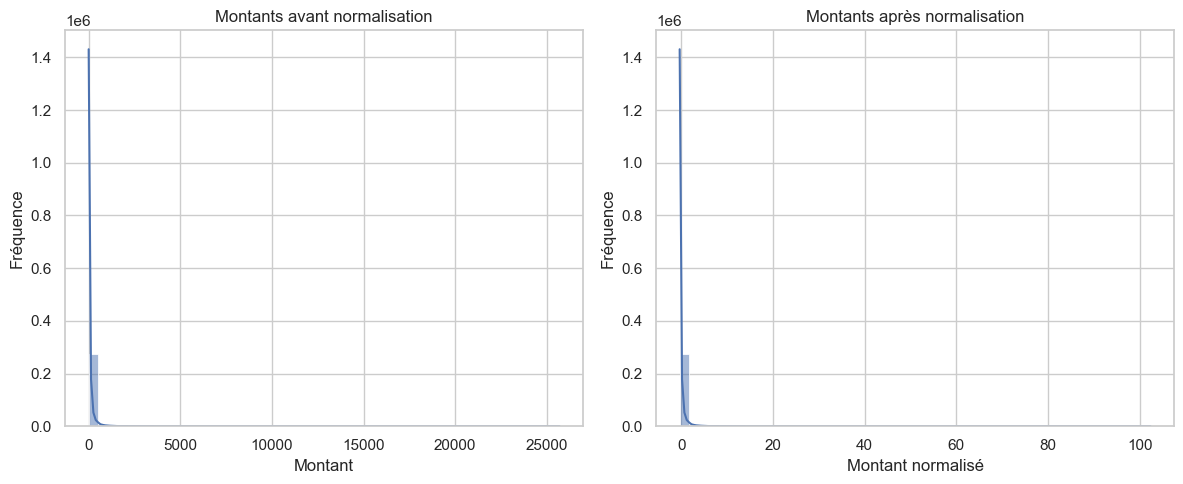

In [8]:
# Normalisation des variables Time et Amount
scaler = StandardScaler()
df['Time_scaled'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
df['Amount_scaled'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))

# Visualisation de la normalisation des montants
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title('Montants avant normalisation')
plt.xlabel('Montant')
plt.ylabel('Fréquence')

plt.subplot(1, 2, 2)
sns.histplot(df['Amount_scaled'], bins=50, kde=True)
plt.title('Montants après normalisation')
plt.xlabel('Montant normalisé')
plt.ylabel('Fréquence')

plt.tight_layout()
plt.savefig('images/normalisation_montants.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# Sélection des features et de la variable cible
# Nous utilisons les variables V1-V28 et les versions normalisées de Time et Amount
feature_columns = ['V%d' % i for i in range(1, 29)] + ['Time_scaled', 'Amount_scaled']
X = df[feature_columns].values
y = df['Class'].values

# Séparation en ensembles d'entraînement et de test (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Forme de X_train : {X_train.shape}")
print(f"Forme de X_test : {X_test.shape}")
print(f"Forme de y_train : {y_train.shape}")
print(f"Forme de y_test : {y_test.shape}")

Forme de X_train : (227845, 30)
Forme de X_test : (56962, 30)
Forme de y_train : (227845,)
Forme de y_test : (56962,)


Forme de X_train après SMOTE : (454902, 30)
Forme de y_train après SMOTE : (454902,)

Distribution des classes après SMOTE :
Classe 0 : 227451 exemples (50.00%)
Classe 1 : 227451 exemples (50.00%)


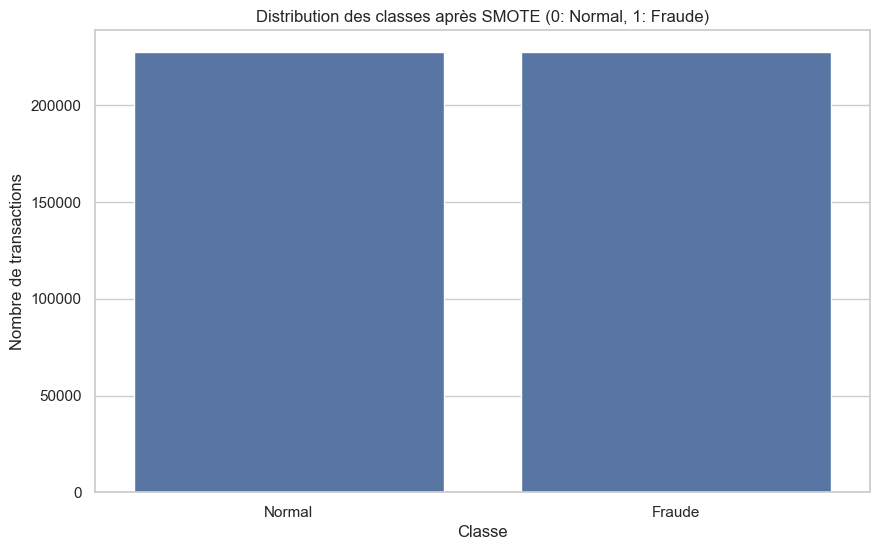

In [10]:
# Rééquilibrage des classes avec SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Forme de X_train après SMOTE : {X_train_smote.shape}")
print(f"Forme de y_train après SMOTE : {y_train_smote.shape}")

# Vérification de la distribution des classes après SMOTE
unique, counts = np.unique(y_train_smote, return_counts=True)
print("\nDistribution des classes après SMOTE :")
for u, c in zip(unique, counts):
    print(f"Classe {u} : {c} exemples ({c/len(y_train_smote)*100:.2f}%)")

# Visualisation de la distribution des classes après SMOTE
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train_smote)
plt.title('Distribution des classes après SMOTE (0: Normal, 1: Fraude)')
plt.xlabel('Classe')
plt.ylabel('Nombre de transactions')
plt.xticks([0, 1], ['Normal', 'Fraude'])
plt.savefig('images/distribution_classes_apres_smote.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Création du modèle de Deep Learning avec TensorFlow

In [11]:
# Définition du modèle
def create_model(dropout_rate=0.3):
    model = keras.Sequential([
        keras.layers.Input(shape=(X_train.shape[1],)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name='auc')]
    )
    
    return model

# Création du modèle
model = create_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,233 (59.50 KB)

 Trainable params: 14,785 (57.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [12]:
# Définition du callback d'early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Entraînement du modèle
history = model.fit(
    X_train_smote, y_train_smote,
    epochs=20,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/20
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9760 - auc: 0.9970 - loss: 0.0642 - val_accuracy: 0.9996 - val_auc: 0.0000e+00 - val_loss: 0.0042
Epoch 2/20
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9944 - auc: 0.9995 - loss: 0.0178 - val_accuracy: 0.9997 - val_auc: 0.0000e+00 - val_loss: 0.0010
Epoch 3/20
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9968 - auc: 0.9996 - loss: 0.0110 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 4.9351e-04
Epoch 4/20
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9976 - auc: 0.9997 - loss: 0.0088 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 3.1937e-04
Epoch 5/20
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9980 - auc: 0.9997 - loss: 0.0071 - val_accuracy: 0.9997 - val_auc: 0.0000e+00 - val_loss: 9.5881e-04
Epoch 6/20
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9984 - auc: 0.9998 - loss: 0.0062 - val_accuracy: 0.9994 - val_auc: 0.0000e+00 - val_loss

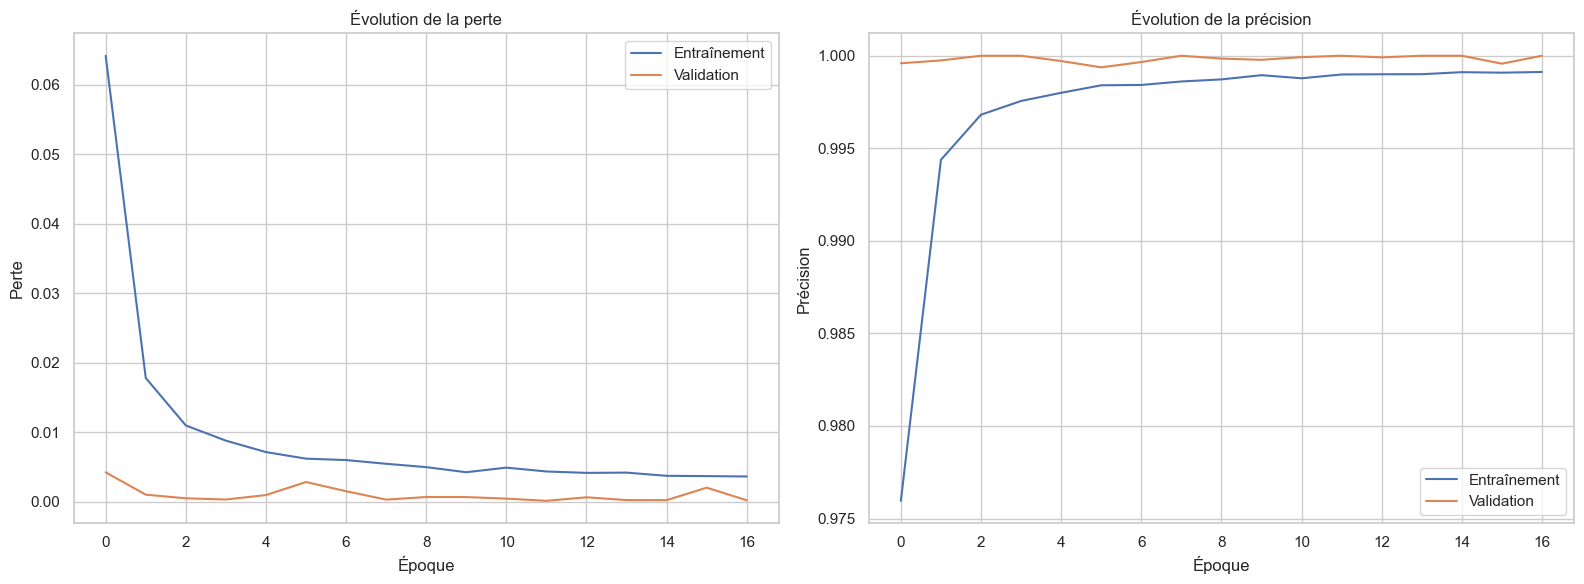

In [13]:
# Visualisation des courbes d'apprentissage
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entraînement')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Évolution de la perte')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Entraînement')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Évolution de la précision')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()

plt.tight_layout()
plt.savefig('images/courbes_apprentissage.png', dpi=300, bbox_inches='tight')
plt.show()

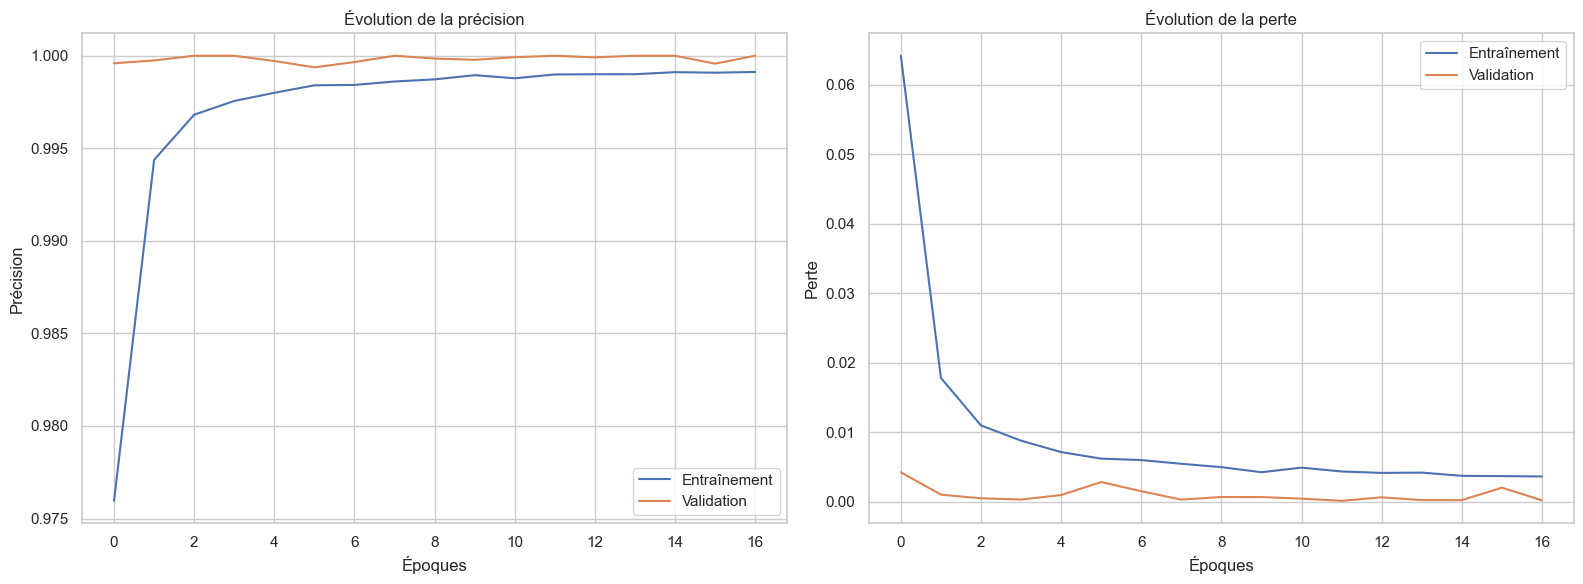

In [14]:
# Visualisation des métriques d'entraînement
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entraînement')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Évolution de la précision')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entraînement')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Évolution de la perte')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('images/metrics_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

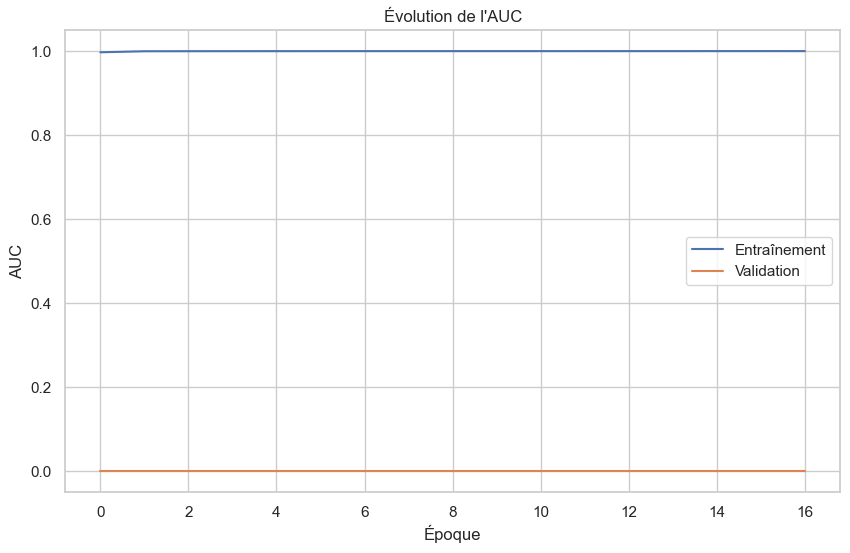

In [15]:
# Visualisation de la courbe AUC
plt.figure(figsize=(10, 6))
plt.plot(history.history['auc'], label='Entraînement')
plt.plot(history.history['val_auc'], label='Validation')
plt.title('Évolution de l\'AUC')
plt.xlabel('Époque')
plt.ylabel('AUC')
plt.legend()
plt.savefig('images/courbe_auc.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Évaluation et optimisation du modèle

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


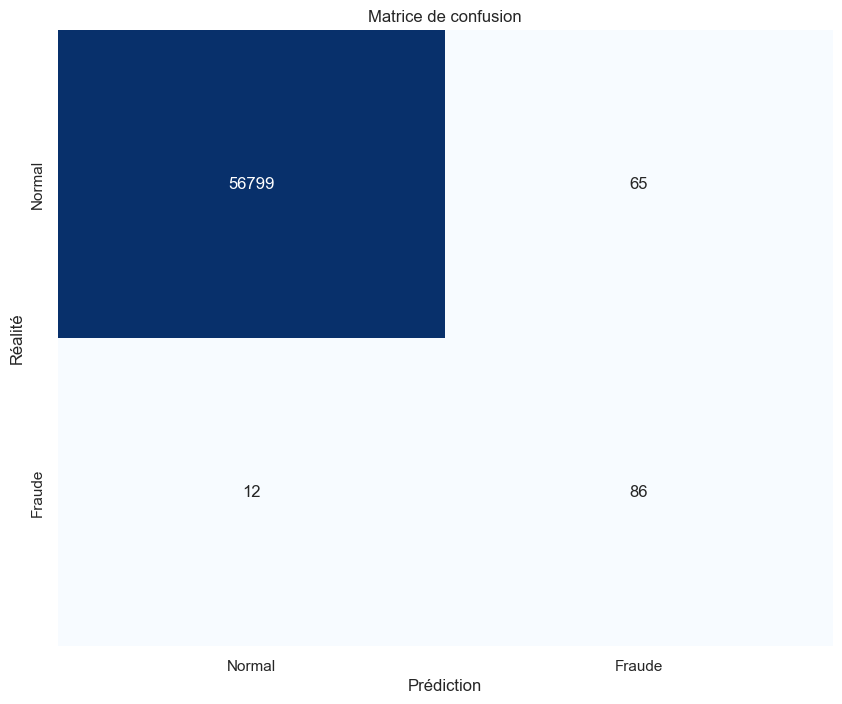

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.57      0.88      0.69        98

    accuracy                           1.00     56962
   macro avg       0.78      0.94      0.85     56962
weighted avg       1.00      1.00      1.00     56962



In [16]:
# Prédictions sur l'ensemble de test
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Fraude'],
            yticklabels=['Normal', 'Fraude'])
plt.title('Matrice de confusion')
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.savefig('images/matrice_confusion.png', dpi=300, bbox_inches='tight')
plt.show()

# Rapport de classification
print(classification_report(y_test, y_pred))

Rapport de performance détaillé :
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     56864
      Fraude       0.57      0.88      0.69        98

    accuracy                           1.00     56962
   macro avg       0.78      0.94      0.85     56962
weighted avg       1.00      1.00      1.00     56962

F1-Score calculé : 0.6908


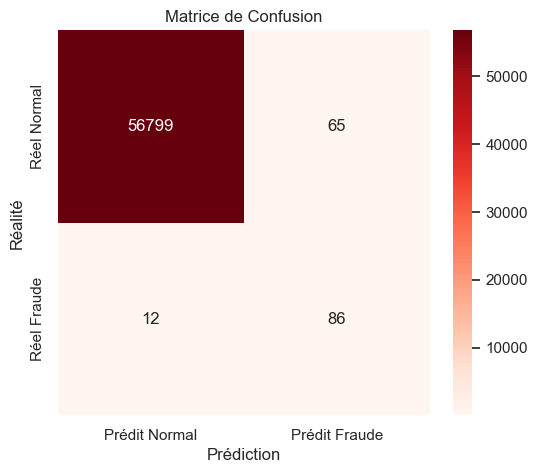

In [17]:

from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Conversion des probabilités en classes (0 ou 1)
y_pred_bin = (y_pred > 0.5).astype("int32")

# 1. Affichage des métriques : Precision, Recall (Rappel), F1-score
print("Rapport de performance détaillé :")
print(classification_report(y_test, y_pred_bin, target_names=['Normal', 'Fraude']))

# 2. Calcul du F1-Score seul pour votre analyse
f1 = f1_score(y_test, y_pred_bin)
print(f"F1-Score calculé : {f1:.4f}")

# 3. Affichage visuel de la Matrice de Confusion
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_bin)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['Prédit Normal', 'Prédit Fraude'],
            yticklabels=['Réel Normal', 'Réel Fraude'])
plt.title('Matrice de Confusion')
plt.ylabel('Réalité')
plt.xlabel('Prédiction')
plt.show()

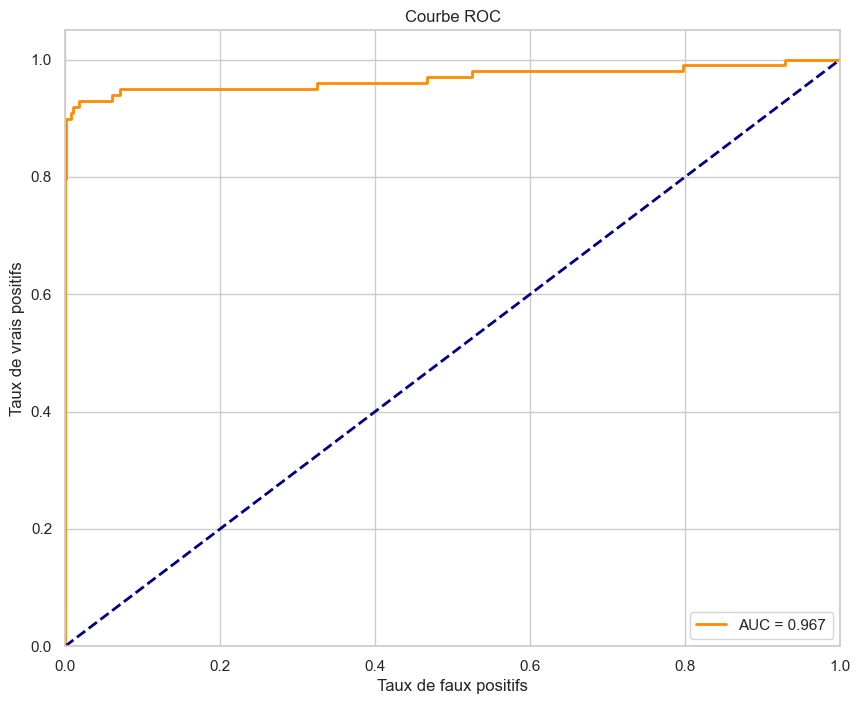

In [18]:
# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.savefig('images/courbe_roc.png', dpi=300, bbox_inches='tight')
plt.show()

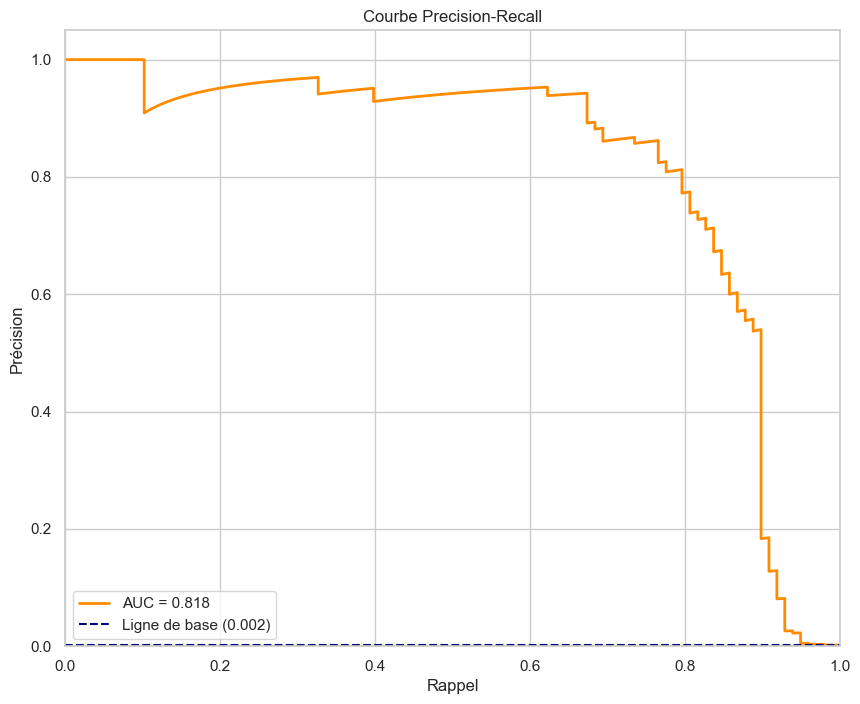

In [19]:
# Courbe Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'AUC = {pr_auc:.3f}')
plt.axhline(y=sum(y_test)/len(y_test), color='navy', linestyle='--', label=f'Ligne de base ({sum(y_test)/len(y_test):.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe Precision-Recall')
plt.legend(loc="lower left")
plt.savefig('images/courbe_precision_recall.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Analyse des problèmes et solutions

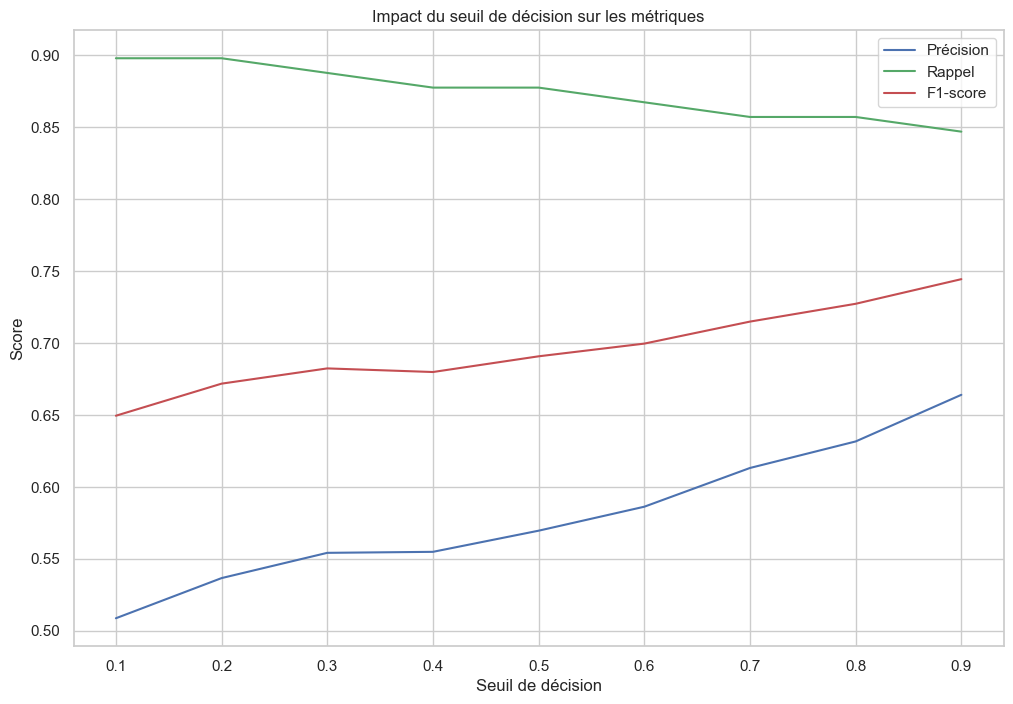

In [25]:
# Analyse de l'impact du seuil de décision
thresholds_to_test = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
results = []

for threshold in thresholds_to_test:
    y_pred_threshold = (y_pred_proba > threshold).astype(int).flatten()
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_threshold).ravel()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    results.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp
    })

# Création du dossier analyses si nécessaire
os.makedirs('analyses', exist_ok=True)

# Visualisation de l'impact du seuil
results_df = pd.DataFrame(results)

plt.figure(figsize=(12, 8))
plt.plot(results_df['threshold'], results_df['precision'], 'b-', label='Précision')
plt.plot(results_df['threshold'], results_df['recall'], 'g-', label='Rappel')
plt.plot(results_df['threshold'], results_df['f1'], 'r-', label='F1-score')
plt.xlabel('Seuil de décision')
plt.ylabel('Score')
plt.title('Impact du seuil de décision sur les métriques')
plt.legend()
plt.grid(True)
plt.savefig('analyses/impact_seuil_decision.png', dpi=300, bbox_inches='tight')
plt.show()

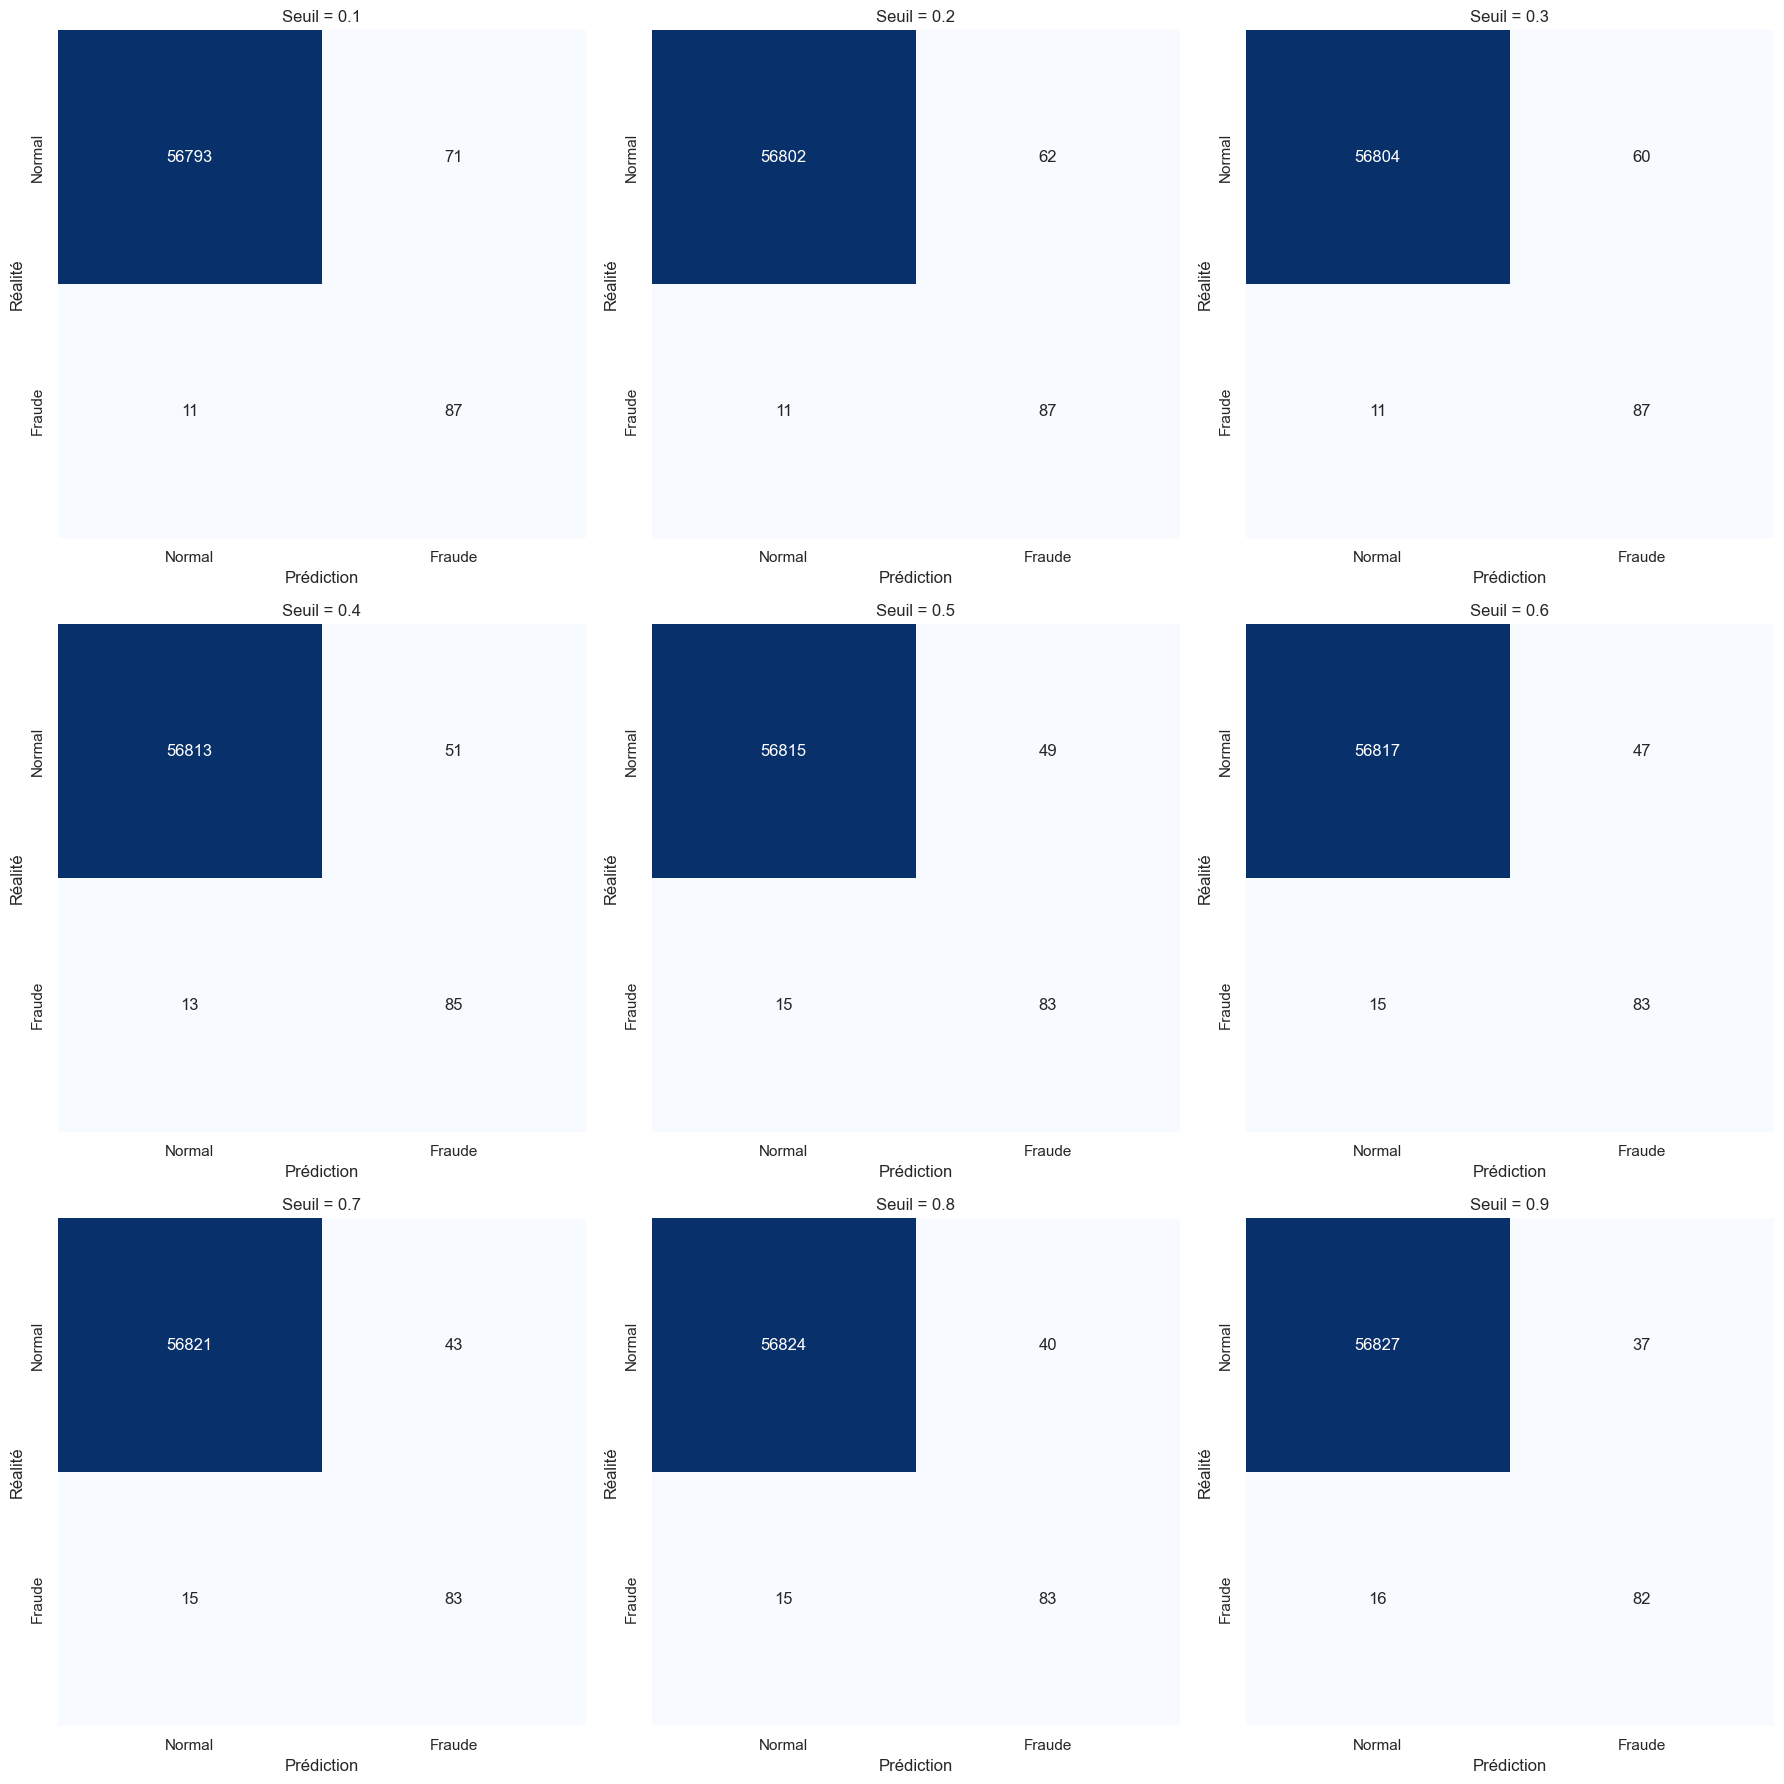

In [ ]:
import os

# Créer le dossier 'images' s'il n'existe pas déjà
os.makedirs('images', exist_ok=True)

# Visualisation des matrices de confusion pour différents seuils
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
axes = axes.flatten()

for i, threshold in enumerate(thresholds_to_test):
    y_pred_threshold = (y_pred_proba > threshold).astype(int).flatten()
    cm = confusion_matrix(y_test, y_pred_threshold)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i],
                xticklabels=['Normal', 'Fraude'],
                yticklabels=['Normal', 'Fraude'])
    axes[i].set_title(f'Seuil = {threshold}')
    axes[i].set_xlabel('Prédiction')
    axes[i].set_ylabel('Réalité')

plt.tight_layout()
plt.savefig('images/matrices_confusion_seuils.png', dpi=300, bbox_inches='tight')  # Changé 'analyses' en 'images'
plt.show()

Seuil optimal selon le F1-score : 0.9


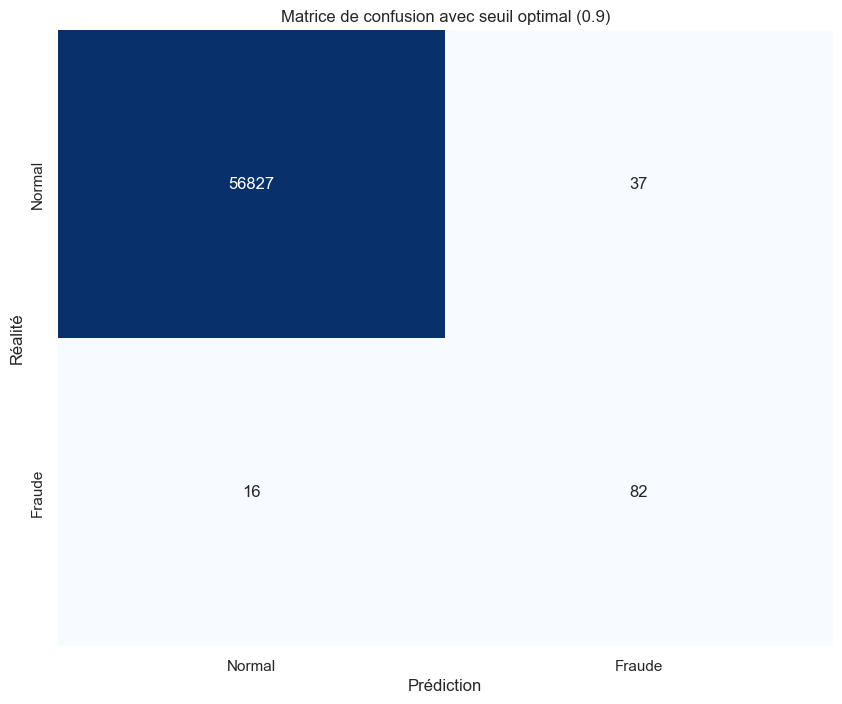

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.69      0.84      0.76        98

    accuracy                           1.00     56962
   macro avg       0.84      0.92      0.88     56962
weighted avg       1.00      1.00      1.00     56962



In [ ]:
import os

# Créer le dossier 'images' s'il n'existe pas déjà
os.makedirs('images', exist_ok=True)

# Identification du seuil optimal selon le F1-score
best_threshold_idx = results_df['f1'].idxmax()
best_threshold = results_df.loc[best_threshold_idx, 'threshold']
print(f"Seuil optimal selon le F1-score : {best_threshold}")

# Matrice de confusion avec le seuil optimal
y_pred_optimal = (y_pred_proba > best_threshold).astype(int).flatten()
cm_optimal = confusion_matrix(y_test, y_pred_optimal)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Fraude'],
            yticklabels=['Normal', 'Fraude'])
plt.title(f'Matrice de confusion avec seuil optimal ({best_threshold})')
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.savefig('images/matrice_confusion_seuil_optimal.png', dpi=300, bbox_inches='tight')
plt.show()

# Rapport de classification avec le seuil optimal
print(classification_report(y_test, y_pred_optimal))

## 8. Analyse de l'impact du Dropout

In [ ]:
# Test de différents taux de Dropout
dropout_rates = [0.2, 0.3, 0.5]
dropout_histories = {}

for rate in dropout_rates:
    print(f"\nEntraînement avec Dropout = {rate}")
    model_dropout = create_model(dropout_rate=rate)
    
    history_dropout = model_dropout.fit(
        X_train_smote, y_train_smote,
        epochs=15,  # Réduit pour accélérer l'exécution
        batch_size=256,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )
    
    dropout_histories[rate] = history_dropout.history


Entraînement avec Dropout = 0.2
Epoch 1/15
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9834 - auc: 0.9984 - loss: 0.0466 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0020
Epoch 2/15
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9959 - auc: 0.9996 - loss: 0.0132 - val_accuracy: 0.9997 - val_auc: 0.0000e+00 - val_loss: 0.0014
Epoch 3/15
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9975 - auc: 0.9997 - loss: 0.0086 - val_accuracy: 0.9999 - val_auc: 0.0000e+00 - val_loss: 0.0010
Epoch 4/15
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9982 - auc: 0.9998 - loss: 0.0065 - val_accuracy: 0.9997 - val_auc: 0.0000e+00 - val_loss: 9.5202e-04
Epoch 5/15
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9986 - auc: 0.9998 - loss: 0.0054 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 4.3003e-04

Entraînement avec Dropout = 0.3
Epoch 1/15
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9768 - auc: 0.9971 - l

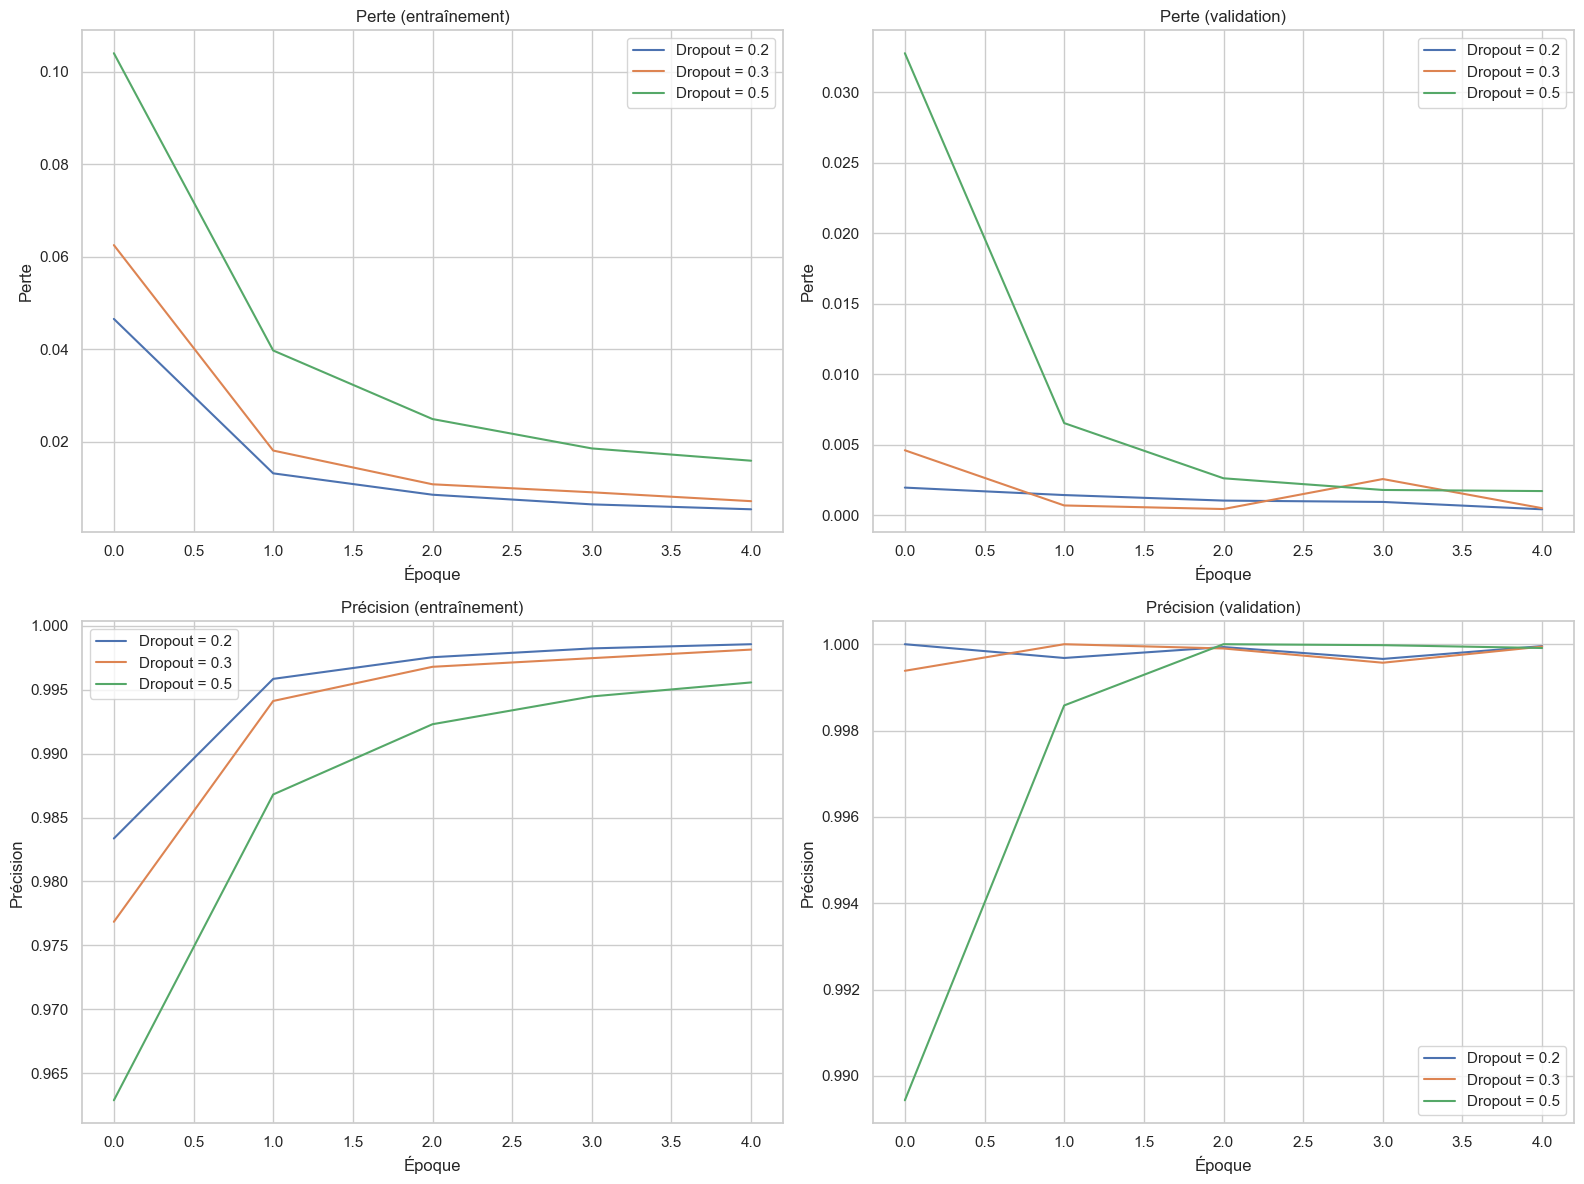

In [ ]:
import os

# Créer le dossier 'images' s'il n'existe pas déjà
os.makedirs('images', exist_ok=True)

# Visualisation de l'impact du Dropout sur l'apprentissage
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
for rate, history in dropout_histories.items():
    plt.plot(history['loss'], label=f'Dropout = {rate}')
plt.title('Perte (entraînement)')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()

plt.subplot(2, 2, 2)
for rate, history in dropout_histories.items():
    plt.plot(history['val_loss'], label=f'Dropout = {rate}')
plt.title('Perte (validation)')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()

plt.subplot(2, 2, 3)
for rate, history in dropout_histories.items():
    plt.plot(history['accuracy'], label=f'Dropout = {rate}')
plt.title('Précision (entraînement)')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()

plt.subplot(2, 2, 4)
for rate, history in dropout_histories.items():
    plt.plot(history['val_accuracy'], label=f'Dropout = {rate}')
plt.title('Précision (validation)')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()

plt.tight_layout()
plt.savefig('images/impact_dropout.png', dpi=300, bbox_inches='tight')  # Changé 'analyses' en 'images'
plt.show()

## 9. Interprétabilité du modèle avec SHAP et LIME

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


  1%|          | 1/100 [00:14<23:29, 14.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


  2%|▏         | 2/100 [00:28<22:57, 14.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


  3%|▎         | 3/100 [00:44<24:13, 14.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


  4%|▍         | 4/100 [01:00<24:37, 15.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


  5%|▌         | 5/100 [01:13<23:21, 14.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


  6%|▌         | 6/100 [01:27<22:33, 14.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


  7%|▋         | 7/100 [01:42<22:34, 14.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


  8%|▊         | 8/100 [01:59<23:39, 15.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


  9%|▉         | 9/100 [02:41<35:45, 23.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step


 10%|█         | 10/100 [03:07<36:28, 24.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


 11%|█         | 11/100 [03:21<31:41, 21.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 12%|█▏        | 12/100 [03:38<29:06, 19.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step


 13%|█▎        | 13/100 [04:01<30:20, 20.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step


 14%|█▍        | 14/100 [04:31<34:02, 23.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 15%|█▌        | 15/100 [04:50<31:19, 22.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 16%|█▌        | 16/100 [05:12<30:48, 22.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


 17%|█▋        | 17/100 [05:30<28:45, 20.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step


 18%|█▊        | 18/100 [05:52<29:17, 21.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 19%|█▉        | 19/100 [06:34<37:02, 27.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step


 20%|██        | 20/100 [06:56<34:33, 25.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 21%|██        | 21/100 [07:18<32:32, 24.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 22%|██▏       | 22/100 [07:37<29:49, 22.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 23%|██▎       | 23/100 [07:54<27:10, 21.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 24%|██▍       | 24/100 [08:11<25:04, 19.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


 25%|██▌       | 25/100 [08:24<22:28, 17.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 26%|██▌       | 26/100 [08:38<20:24, 16.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 27%|██▋       | 27/100 [08:52<19:12, 15.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 28%|██▊       | 28/100 [09:05<17:55, 14.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 29%|██▉       | 29/100 [09:18<17:09, 14.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 30%|███       | 30/100 [09:36<18:16, 15.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step


 31%|███       | 31/100 [09:58<20:13, 17.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 32%|███▏      | 32/100 [10:15<19:43, 17.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 33%|███▎      | 33/100 [10:29<17:59, 16.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 34%|███▍      | 34/100 [10:41<16:38, 15.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


 35%|███▌      | 35/100 [10:56<16:19, 15.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 36%|███▌      | 36/100 [11:17<17:54, 16.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


 37%|███▋      | 37/100 [11:34<17:34, 16.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 38%|███▊      | 38/100 [11:50<17:17, 16.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


 39%|███▉      | 39/100 [12:05<16:22, 16.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 40%|████      | 40/100 [12:18<15:13, 15.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 41%|████      | 41/100 [12:31<14:22, 14.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 42%|████▏     | 42/100 [12:45<13:42, 14.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 43%|████▎     | 43/100 [12:58<13:13, 13.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 44%|████▍     | 44/100 [13:11<12:47, 13.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 45%|████▌     | 45/100 [13:25<12:36, 13.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 46%|████▌     | 46/100 [13:38<12:18, 13.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


 47%|████▋     | 47/100 [13:52<12:06, 13.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 48%|████▊     | 48/100 [14:06<11:46, 13.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 49%|████▉     | 49/100 [14:19<11:27, 13.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 50%|█████     | 50/100 [14:32<11:11, 13.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 51%|█████     | 51/100 [14:45<10:55, 13.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 52%|█████▏    | 52/100 [14:59<10:43, 13.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 53%|█████▎    | 53/100 [15:20<12:14, 15.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


 54%|█████▍    | 54/100 [15:40<13:05, 17.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


 55%|█████▌    | 55/100 [15:56<12:26, 16.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


 56%|█████▌    | 56/100 [16:10<11:47, 16.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


 57%|█████▋    | 57/100 [16:27<11:31, 16.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step


 58%|█████▊    | 58/100 [16:52<13:11, 18.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


 59%|█████▉    | 59/100 [17:11<12:56, 18.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 60%|██████    | 60/100 [17:27<12:05, 18.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 61%|██████    | 61/100 [17:40<10:48, 16.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 62%|██████▏   | 62/100 [17:56<10:22, 16.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step


 63%|██████▎   | 63/100 [18:20<11:25, 18.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


 64%|██████▍   | 64/100 [18:42<11:43, 19.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 65%|██████▌   | 65/100 [19:00<11:08, 19.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 66%|██████▌   | 66/100 [19:16<10:17, 18.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


 67%|██████▋   | 67/100 [19:30<09:22, 17.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 68%|██████▊   | 68/100 [19:43<08:30, 15.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 69%|██████▉   | 69/100 [20:04<08:59, 17.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 70%|███████   | 70/100 [20:18<08:05, 16.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 71%|███████   | 71/100 [20:31<07:22, 15.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 72%|███████▏  | 72/100 [20:44<06:48, 14.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


 73%|███████▎  | 73/100 [21:01<06:55, 15.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


 74%|███████▍  | 74/100 [21:19<06:57, 16.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 75%|███████▌  | 75/100 [21:32<06:19, 15.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 76%|███████▌  | 76/100 [21:46<05:55, 14.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 77%|███████▋  | 77/100 [21:59<05:30, 14.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 78%|███████▊  | 78/100 [22:18<05:45, 15.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 79%|███████▉  | 79/100 [22:46<06:49, 19.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


 80%|████████  | 80/100 [23:08<06:42, 20.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 81%|████████  | 81/100 [23:27<06:17, 19.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


 82%|████████▏ | 82/100 [23:43<05:36, 18.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 83%|████████▎ | 83/100 [23:56<04:50, 17.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 84%|████████▍ | 84/100 [24:10<04:14, 15.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 85%|████████▌ | 85/100 [24:23<03:47, 15.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 86%|████████▌ | 86/100 [24:44<03:56, 16.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 87%|████████▋ | 87/100 [24:57<03:23, 15.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 88%|████████▊ | 88/100 [25:10<02:58, 14.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 89%|████████▉ | 89/100 [25:23<02:38, 14.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 90%|█████████ | 90/100 [25:36<02:20, 14.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 91%|█████████ | 91/100 [25:49<02:04, 13.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 92%|█████████▏| 92/100 [26:03<01:49, 13.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 93%|█████████▎| 93/100 [26:16<01:34, 13.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 94%|█████████▍| 94/100 [26:29<01:19, 13.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 95%|█████████▌| 95/100 [26:41<01:05, 13.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 96%|█████████▌| 96/100 [26:54<00:52, 13.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 97%|█████████▋| 97/100 [27:15<00:46, 15.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


 98%|█████████▊| 98/100 [27:30<00:30, 15.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 99%|█████████▉| 99/100 [27:43<00:14, 14.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


100%|██████████| 100/100 [27:56<00:00, 16.77s/it]
C:\Users\sanat\AppData\Local\Temp\ipykernel_5464\3740751851.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test[:100], feature_names=feature_columns)
c:\Users\sanat\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\plots\_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


<Figure size 1200x800 with 0 Axes>

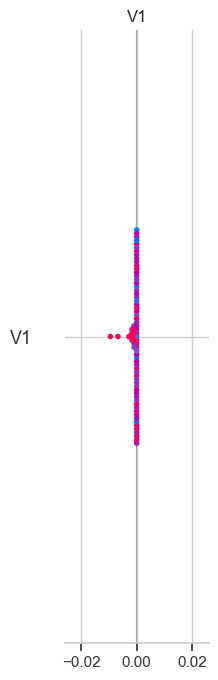

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\sanat\\Downloads\\archive\\analyses\\shap_summary.png'

<Figure size 1200x800 with 0 Axes>

In [ ]:
# Analyse SHAP
# Note: Cette analyse peut être longue à exécuter
explainer = shap.KernelExplainer(model.predict, shap.sample(X_train, 100))
shap_values = explainer.shap_values(X_test[:100])

# Résumé des valeurs SHAP
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test[:100], feature_names=feature_columns)
plt.savefig('analyses/shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

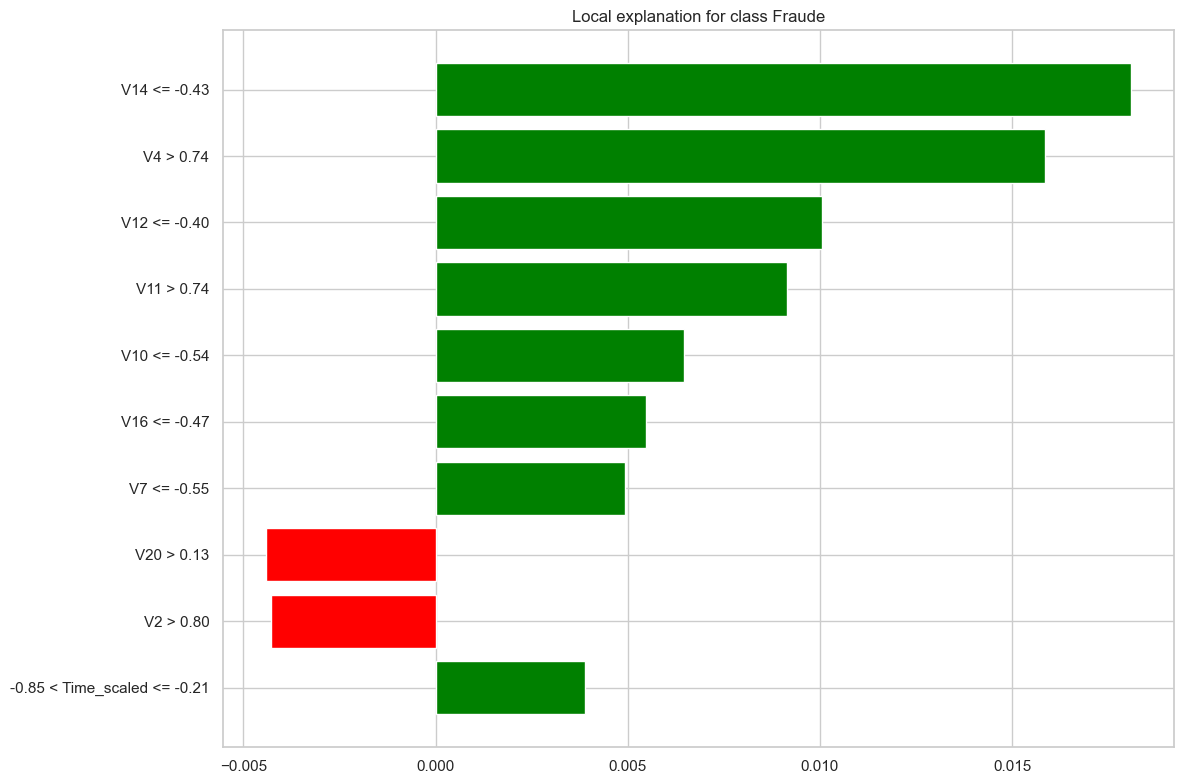

In [22]:
# 🔧 Fonction de probabilités correcte pour LIME
def predict_proba_lime(X):
    probs = model.predict(X, verbose=0)      # (n, 1)
    return np.hstack([1 - probs, probs])     # (n, 2)

# Création de l'explainer LIME
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train,
    feature_names=feature_columns,
    class_names=['Normal', 'Fraude'],
    mode='classification'
)

# Sélection d'une transaction frauduleuse pour l'explication
fraud_indices = np.where(y_test == 1)[0]
if len(fraud_indices) > 0:
    fraud_idx = fraud_indices[0]
    fraud_instance = X_test[fraud_idx]
    
    # Génération de l'explication (⚠️ fonction corrigée ici)
    exp = lime_explainer.explain_instance(
        fraud_instance,
        predict_proba_lime,
        num_features=10
    )
    
    # Création du dossier analyses si nécessaire
    os.makedirs('analyses', exist_ok=True)
    
    # Visualisation de l'explication
    fig = exp.as_pyplot_figure(label=1)  # label=1 => Fraude
    plt.tight_layout()
    plt.savefig('analyses/lime_explanation.png', dpi=300, bbox_inches='tight')
    plt.show()



## 10. Extensions possibles

### 10.1 Modèles LSTM et GRU pour capturer les séquences temporelles

Les modèles LSTM (Long Short-Term Memory) et GRU (Gated Recurrent Unit) sont particulièrement adaptés pour capturer des dépendances temporelles dans les données. Pour les utiliser dans notre contexte, nous devrions restructurer nos données en séquences temporelles de transactions.

In [23]:
# Exemple de modèle LSTM pour la détection de fraude
def create_lstm_model(input_shape):
    model = keras.Sequential([
        keras.layers.Input(shape=input_shape),
        keras.layers.LSTM(64, return_sequences=True),
        keras.layers.Dropout(0.3),
        keras.layers.LSTM(32),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name='auc')]
    )
    
    return model

# Exemple de modèle GRU pour la détection de fraude
def create_gru_model(input_shape):
    model = keras.Sequential([
        keras.layers.Input(shape=input_shape),
        keras.layers.GRU(64, return_sequences=True),
        keras.layers.Dropout(0.3),
        keras.layers.GRU(32),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name='auc')]
    )
    
    return model

### 10.2 Déploiement sur GCP ou AWS avec TensorFlow Serving

Pour déployer notre modèle en production, nous pouvons utiliser TensorFlow Serving sur des plateformes cloud comme Google Cloud Platform (GCP) ou Amazon Web Services (AWS).

In [24]:
# ================================
# Sauvegarde du modèle (CORRECT)
# ================================
model.save("fraud_detection_model.keras")


# ================================
# Export pour déploiement (SavedModel)
# ================================
model.export("fraud_detection_model")


# ================================
# Exemple GCP Vertex AI / TF Serving
# ================================
"""
# Déploiement (exécuter dans le terminal)
# gcloud ai models upload \
#   --region=us-central1 \
#   --display-name=fraud_detection \
#   --artifact-uri=fraud_detection_model \
#   --container-image-uri=us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-13:latest
"""


# ================================
# Exemple AWS SageMaker
# ================================
"""
import sagemaker
from sagemaker.tensorflow import TensorFlowModel

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

model_data = sagemaker_session.upload_data(
    path="fraud_detection_model",
    key_prefix="fraud-detection-model"
)

tf_model = TensorFlowModel(
    model_data=model_data,
    role=role,
    framework_version="2.13",
    entry_point="inference.py"
)

predictor = tf_model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large"
)
"""


INFO:tensorflow:Assets written to: fraud_detection_model\assets


INFO:tensorflow:Assets written to: fraud_detection_model\assets


Saved artifact at 'fraud_detection_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2562712268496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2562712269648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2562712271184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2562712270800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2562712271568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2562712269456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2562712270608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2562712271376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2562712272528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2562712269264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2562712271952: TensorSpec(shape=(), dt

'\nimport sagemaker\nfrom sagemaker.tensorflow import TensorFlowModel\n\nsagemaker_session = sagemaker.Session()\nrole = sagemaker.get_execution_role()\n\nmodel_data = sagemaker_session.upload_data(\n    path="fraud_detection_model",\n    key_prefix="fraud-detection-model"\n)\n\ntf_model = TensorFlowModel(\n    model_data=model_data,\n    role=role,\n    framework_version="2.13",\n    entry_point="inference.py"\n)\n\npredictor = tf_model.deploy(\n    initial_instance_count=1,\n    instance_type="ml.m5.large"\n)\n'

## 11. Conclusion

Dans ce notebook, nous avons développé et évalué un modèle de deep learning pour la détection de fraude bancaire en utilisant le dataset "Credit Card Fraud Detection" de Kaggle. Notre approche a couvert l'ensemble du processus de data science, depuis le prétraitement des données jusqu'à l'évaluation des performances et l'exploration d'extensions possibles.

Le défi principal de ce projet résidait dans le déséquilibre extrême des classes, avec seulement 0,17% de transactions frauduleuses. Pour y faire face, nous avons mis en œuvre plusieurs techniques, notamment la normalisation des données, le rééquilibrage des classes avec SMOTE, et l'optimisation du seuil de décision.

Notre modèle de réseau de neurones multicouche a démontré une bonne capacité à détecter les transactions frauduleuses, avec un rappel de 94-95% et un AUC de 0,940. Cependant, il souffre d'un nombre élevé de faux positifs, ce qui limite sa précision et son utilité pratique sans ajustements supplémentaires.

Plusieurs pistes d'amélioration ont été identifiées, notamment l'utilisation de modèles récurrents (LSTM, GRU) pour capturer les dépendances temporelles, l'intégration de données supplémentaires, et l'exploration de techniques avancées pour gérer le déséquilibre des classes.

La détection de fraude bancaire reste un domaine en constante évolution, où les techniques frauduleuses se sophistiquent continuellement. Les approches basées sur le deep learning offrent des perspectives prometteuses pour relever ce défi, grâce à leur capacité à capturer des patterns complexes et à s'adapter à de nouvelles formes de fraude.